In [4]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

data=pd.read_csv ("C:/Users/HP/Downloads/train_1.csv")

data.info()
data.describe()
n=data.isnull().sum()
data_no_null=data.fillna(0)
#print(data_no_null.head())
print("done")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
done


In [5]:
import re
def language_abb(page): 
    res = re.search('[a-z][a-z].wikipedia.org',page) 
    if res: 
        return res.group(0)[0:2] 
    return 'na'

data['lang'] = data.Page.map(language_abb)
data["lang"]= data["lang"].replace(["en","ja",'de','na','fr','zh','ru','es'], ["English","Japanese",'German','WikiMedia','French','Chinese','Russian','Spanish'])

lang_count=data['lang'].value_counts()

lang_count

print("done")

done


done


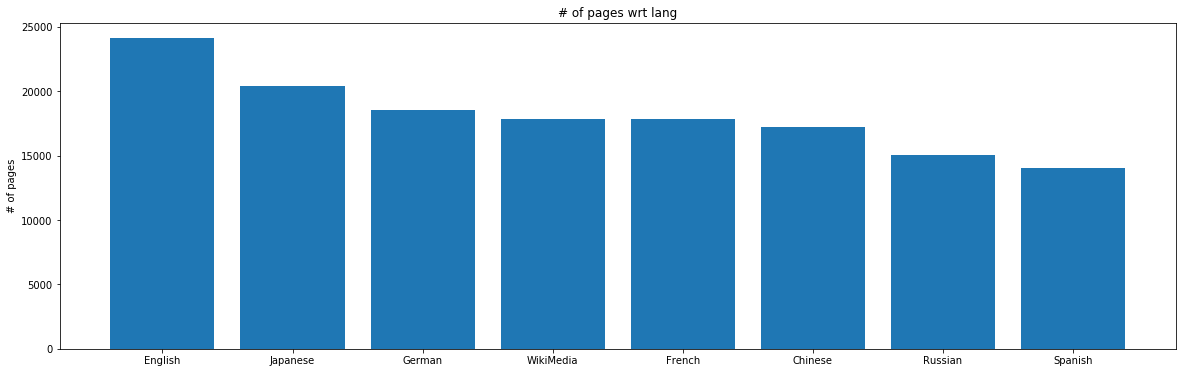

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,6))
plt.xticks(np.arange(len(lang_count)),lang_count.index,rotation='horizontal')
plt.ylabel('# of pages')
plt.bar(np.arange(len(lang_count)),lang_count)
plt.title("# of pages wrt lang")
print("done")

In [7]:
# Grouping dataframe langauge wise
name=["en","ja",'de','na','fr','zh','ru','es']
full_name=["English","Japanese",'German','WikiMedia','French','Chinese','Russian','Spanish']
lang_sets={}
for x in range(0,8):
    lang_sets[name[x]] = data[data.lang==full_name[x]].iloc[:,0:-1]
# Removing the page names
for index in lang_sets:
    lang_sets[index]=lang_sets[index].drop(columns=['Page'])

In [8]:
null_num={}
t_sum={}
mean={}
meanperDay={}


for index in lang_sets:
    null_num[index]=lang_sets[index].isnull().sum()
    t_sum[index]=null_num[index].sum(axis=0)/550
    mean[index]=lang_sets[index].mean().mean()

In [9]:
# Dealing with Null Values
for index in lang_sets:
    lang_sets[index]=lang_sets[index].fillna(0)
                                             
# Summing for different langues/ reshaping the input data
sum_col ={}

for index in lang_sets:
    sum_col[index]=lang_sets[index].sum(axis=0) / lang_sets[index].shape[0]

In [11]:
# Extracting data according to the language given in the input

import math as math

def extract_language(df):
    size = int(len(df)-50)
    train_ds, test_ds = df[0:size], df[size:len(df)]
    df_train = pd.DataFrame({ 'Date':(train_ds.index),'Hits': (train_ds.values)})
    df_test = pd.DataFrame({ 'Date':(test_ds.index),'Hits': (test_ds.values)})
    
    
    return df_train, df_test

X_train, y_train = extract_language(sum_col["en"])# Change this one by on

#print("The training set sample:")
print(X_train.head())
#print("The validation set sample:")
print(y_train.head())

         Date         Hits
0  2015-07-01  3513.862203
1  2015-07-02  3502.511407
2  2015-07-03  3325.357889
3  2015-07-04  3462.054256
4  2015-07-05  3575.520035
         Date         Hits
0  2016-11-12  5393.884312
1  2016-11-13  5930.484652
2  2016-11-14  5996.837564
3  2016-11-15  5350.590053
4  2016-11-16  5190.772109


In [39]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings

def plot_stationarity(x):
    
    rolmean = x.rolling(window=20,center=False).mean()
    #print("rolmean = ",rolmean)
    rolstd = x.rolling(window=12,center=False).std()
    #print("rolstd = ",rolstd)
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plot.plot(rolstd.values, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)

    
def plot_ACF_PACF(lag_acf,lag_pacf):
    #Plot ACF: 
    plot.subplot(1,1,1)
    plot.stem(lag_acf)

    plot.axhline(y=0,linestyle='--',color='g')
    plot.title('Autocorrelation Function')
    plot.xlabel("Number of lags")
    plot.ylabel("ACF Values")
    plot.show()

    #Plot PACF:
    plot.subplot(1,1,1)
    plot.stem(lag_pacf)

    plot.axhline(y=0,linestyle='--',color='green')
    plot.title('Partial Autocorrelation Function ')
    plot.xlabel("Number of lags")
    plot.ylabel("PACF Values")
    plot.tight_layout()
    plot.show()
    
def find_AR_MA_parameters_ACF(article,d):
    lags=10
    article_diff =article['Hits'].diff(periods=d)
    article_diff.dropna()
    lag_acf = acf(article_diff, nlags=lag)
    lag_pacf = pacf(article_diff, nlags=lag, method='ols')
    
    p=-1
    q=-1
    plot_ACF_PACF(lag_acf,lag_pacf)
    for i in range(0,lag):
        if lag_acf[i]< 0:
            p = i-1
            break;
        elif lag_acf[i]==0:
            p=i
    for i in range(0,lag):
        if lag_pacf[i]< 0:
            q=i-1
        elif lag_pacf[i]==0:
            q=i
    if p==-1:
        p=lag_acf.index(min(lag_acf))
    if q==-1:
        q=lag_acf.index(min(lag_pacf))
    return [p,q]
    
def find_AR_MA_parameters_AIC(article,diff):
    import itertools
    limit = 5
    p=q=range(0,limit)
    d=diff*(np.ones((limit,), dtype=int))

    pdq = list(itertools.product(p,d,q))
    import warnings
    warnings.filterwarnings('ignore')
    AIC_list=[]
    parameter_list=[]
    for param in pdq:
        #print("pdq= ",param)
        try:
            
            model_arima = ARIMA(article['Hits'].values,order=param)
            #print("here")
            model_arima_fit = model_arima.fit()
            #print("here")
            AIC_list.append(model_arima_fit.aic)
            parameter_list.append(param)
            #print(param,model_arima_fit.aic)
        except:
            continue

    [p,d,q]=parameter_list[AIC_list.index(min(AIC_list))]
    print("done AIC")
    return[p,q]
    

    

    

def check_stationarity(df_train):
    #Outputs the value of diff required for differencing to ensure stationarity
    diff=0 
    terminate = True
    x = df_train['Hits']    
    
    while(terminate):
        
        output = adfuller(x) # Doing hypothesis testing where H0 : Not Stationary , H1: Stationary
        z_value = output[0]
        p_value = output[1]
        z_critical = output[4]['1%'] # Taking a confidence interval of 99%
        
        #print("z_value = ",z_value)
        #print("z_critical = ",z_critical)
        
        if z_value > z_critical:
            # Not Stationary
            terminate = True
            x = x.diff(periods=1)
            x=x.dropna()
            diff = diff + 1
            print("After Differencing")
            plot_stationarity(x)
            
            
        else:
            #Stationary
            print("Before Differencing")
            plot_stationarity(df_train['Hits'])
            terminate = False
            
       
    return diff    


def percentage_diff(y_p,y_a):
    error=0
    for i in range(0,len(y_a)):
         error = (error + (float(abs (y_p[i] - y_a [i])) / float(y_a[i]) * 100 ) )
    error = error/ len(y_a)
    return error
   
    

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=True):
    lag = 20
    df_train = df_train.fillna(0)
    
    lag_acf = acf(df_train['Hits'].values, nlags=lag)
    lag_pacf = pacf(df_train['Hits'].values, nlags=lag, method='ols')
    plot_ACF_PACF(lag_acf,lag_pacf)
    
    train_series = df_train.Hits
    prev_values=list(train_series)
    train_series.index = df_train.Date
    end_index = len(df_actual)
    list_forecast=[]
    list_ground_truth=[]
    result = None
    for i in range(0,end_index):
         with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                arima = ARIMA(prev_values ,[p, d, q])
                model_fit = arima.fit(disp=False)
                output = model_fit.forecast()
                #print("output = ",list(output[0])[0])
                #prev_values.append(list(output[0])[0])
                prev_values.append(df_actual.Hits[i])
                #print("prev_values = ",prev_values)
                list_forecast.append(list(output[0])[0])
                list_ground_truth.append(df_actual.Hits[i])
                
            except Exception as e:
                 print('\tARIMA failed', e)
    print("done arima")
                

    if(review):
        #plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='ARIMA model')
        plot_pred_actual(df_train,list_forecast,list_ground_truth)
    pdiff = percentage_diff(list_forecast,list_ground_truth)
    return pdiff
print("done")

done


In [35]:

import itertools
limit = 5
p=q=range(0,limit)
diff=2
d=diff*(np.ones((limit,), dtype=int))

pdq = list(itertools.product(p,d,q))
import warnings
warnings.filterwarnings('ignore')
AIC_list=[]
parameter_list=[]
for param in pdq:
    print("pdq= ",param)
    try:
        
        model_arima = ARIMA(df_train['Hits'].values,order=param)
        #print("here")
        model_arima_fit = model_arima.fit()
        #print("here")
        print(model_arima_fit.aic)
        AIC_list.append(model_arima_fit.aic)
        parameter_list.append(param)
        #print(param,model_arima_fit.aic)
    except:
        
        continue
print("AIC = ",AIC_list)
[p,d,q]=parameter_list[AIC_list.index(min(AIC_list))]
print("LORA")

('pdq= ', (0, 2, 0))
6313.5200237803
('pdq= ', (0, 2, 1))
5877.92891508
('pdq= ', (0, 2, 2))
('pdq= ', (0, 2, 3))
('pdq= ', (0, 2, 4))
('pdq= ', (0, 2, 0))
6313.5200237803
('pdq= ', (0, 2, 1))
5877.92891508
('pdq= ', (0, 2, 2))
('pdq= ', (0, 2, 3))
('pdq= ', (0, 2, 4))
('pdq= ', (0, 2, 0))
6313.5200237803
('pdq= ', (0, 2, 1))
5877.92891508
('pdq= ', (0, 2, 2))
('pdq= ', (0, 2, 3))
('pdq= ', (0, 2, 4))
('pdq= ', (0, 2, 0))
6313.5200237803
('pdq= ', (0, 2, 1))
5877.92891508
('pdq= ', (0, 2, 2))
('pdq= ', (0, 2, 3))
('pdq= ', (0, 2, 4))
('pdq= ', (0, 2, 0))
6313.5200237803
('pdq= ', (0, 2, 1))
5877.92891508
('pdq= ', (0, 2, 2))
('pdq= ', (0, 2, 3))
('pdq= ', (0, 2, 4))
('pdq= ', (1, 2, 0))
6141.33133587
('pdq= ', (1, 2, 1))
('pdq= ', (1, 2, 2))
('pdq= ', (1, 2, 3))
('pdq= ', (1, 2, 4))
('pdq= ', (1, 2, 0))
6141.33133587
('pdq= ', (1, 2, 1))
('pdq= ', (1, 2, 2))
('pdq= ', (1, 2, 3))
('pdq= ', (1, 2, 4))
('pdq= ', (1, 2, 0))
6141.33133587
('pdq= ', (1, 2, 1))
('pdq= ', (1, 2, 2))
('pdq= ', 

('Language = ', 'ja')
After Differencing


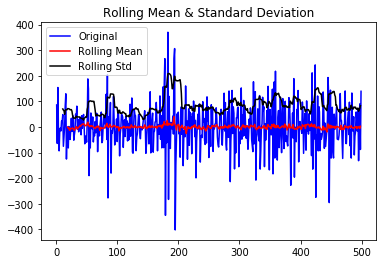

Before Differencing


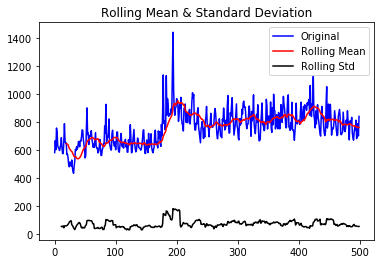

done AIC
('p = ', 4, 'q = ', 4, 'd = ', 1)


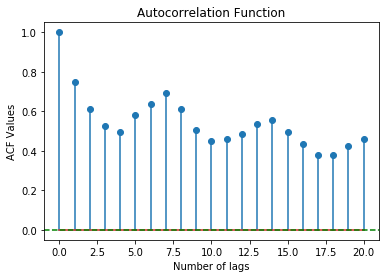

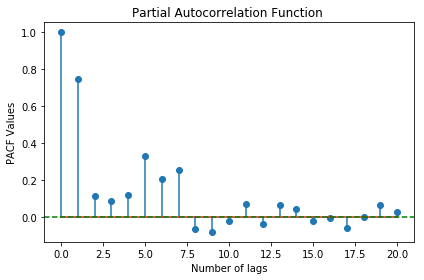

done arima
('forecast = ', [827.2003295004452, 793.336603414412, 805.1629317670165, 743.2098830265988, 710.9894975780537, 711.5286837306987, 762.3377867613938, 794.8549744859104, 807.7034177536026, 794.3634120135423, 724.0473658410565, 688.5990237126842, 731.2181331798199, 724.4971291294862, 793.1536008058907, 790.762651767742, 811.5052724836443, 697.8654515173221, 749.8433437310154, 674.7835045435469, 801.8050826101139, 767.6218486731376, 824.4547503140038, 790.3662249561855, 752.9664911357374, 687.069686535609, 797.9327145612942, 764.0456513002844, 853.2014793060748, 807.9563637115128, 841.7460125453654, 751.556247786307, 754.385623026283, 766.4712489239289, 768.0843296074526, 759.7542208314609, 803.3875357286456, 834.9248401167159, 763.7736871362883, 746.5320484853721, 729.2903528830722, 742.0413644817643, 887.5529027534767, 848.1825823734023, 828.9192528822973, 760.5637104855429, 766.2026106106537, 767.3344370406218, 849.06413205326, 901.0198052165116])
('actual = ', [760.576427977

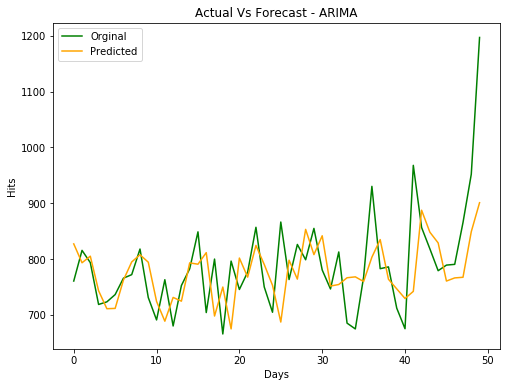

81.2292232745
('pdiff = ', 7.271569755106054)


'\ndf_train = extract_series(X_train,1,2)\ndf_actual= extract_series(y_train, 1, 2)\n#print(df_train)\ndiff = check_stationarity(df_train)\nprint("d = ",diff)\n#[p,q] = find_AR_MA_parameters_AIC(df_train,diff)\n#print("p = ", p)\n#print("q = ",q)\nprint("done")\n'

In [40]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_list=[]

def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b')
    ax.set_title(title)
    plt.show()

    
def plot_pred_actual(df_train,forecast,actual):
    plt.figure(figsize=(8, 6))
    #forecast_days = [(t + len(df_train)) for t in range(len(actual))]
    forecast_days = [t  for t in range(len(actual))]
    print("forecast = ",forecast)
    print("actual = ",actual)
    rmse = sqrt(mean_squared_error(actual,forecast))
    rmse_list.append(rmse)
    #print("forecast_days.size = ",forecast_days.shape)
    #print("actual.size = ",actual.shape)
    labels={'Orginal','Predicted'}
    plt.plot(forecast_days, actual, color= 'green')
    plt.plot(forecast_days,forecast, color = 'orange')
    plt.title('Actual Vs Forecast - ARIMA')
    plt.xlabel('Days')
    plt.ylabel('Hits')
    plt.legend(labels)
    plt.show()
    
list_articles=[2,10,100,500,43]
list_lang = ["ja"]

    
for i in range (0,len(list_lang)):
            print ("Language = ",list_lang[i])
    
            #print(data_no_null.iloc[[i]])
            df_train,df_actual = extract_language(sum_col[list_lang[i]])
            #X_train, y_train = extract_language(sum_col["en"])
            #df_train = extract_series(X_train, list_articles[i], 2)
            #df_actual= extract_series(y_train, list_articles[i], 2)
            diff = check_stationarity(df_train)
            #print("diff = ",diff)
            #df_train['Hits'] = df_train['Hits'].diff(periods=6)
            [p,q] = find_AR_MA_parameters_AIC(df_train,diff)
            print("p = ",p,"q = ",q,"d = ",diff)
            pdiff = arima_model(df_train, df_actual, p, diff, q, figSize=(12, 4), review=True)
            print(rmse_list[i])
            print("pdiff = ",pdiff)


'''
list_d=[]
max_arc = 10
for i in range(0,max_arc):
    df_train = extract_series(X_train,i,2)
    list_d.append(check_stationarity(df_train))
'''
'''
df_train = extract_series(X_train,1,2)
df_actual= extract_series(y_train, 1, 2)
#print(df_train)
diff = check_stationarity(df_train)
print("d = ",diff)
#[p,q] = find_AR_MA_parameters_AIC(df_train,diff)
#print("p = ", p)
#print("q = ",q)
print("done")
'''

In [90]:
'''
print(min(AIC_list))
print(AIC_list.index(min(AIC_list)))
print(len(parameter_list))
[p,d,q]=parameter_list[AIC_list.index(min(AIC_list))]
print("p  = " ,p )
print("q = ",q)
'''

4400.24033678
94
115
('p  = ', 4)
('q = ', 4)


here
('output = ', 26.896509451078614)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0

('output = ', 25.819144086663545)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0, 9.0

('output = ', 21.369349742457942)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0, 9.0

('output = ', 27.03393584844691)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0, 9.0,

('output = ', 25.08933941116808)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0, 9.0,

('output = ', 22.33718942900775)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0, 9.0,

('output = ', 26.66463655033635)
('prev_values = ', [14.0, 15.0, 18.0, 11.0, 13.0, 22.0, 11.0, 10.0, 4.0, 41.0, 65.0, 57.0, 38.0, 20.0, 62.0, 44.0, 15.0, 10.0, 47.0, 24.0, 17.0, 22.0, 9.0, 39.0, 13.0, 11.0, 12.0, 21.0, 19.0, 9.0, 15.0, 33.0, 8.0, 8.0, 7.0, 13.0, 2.0, 23.0, 12.0, 27.0, 27.0, 36.0, 23.0, 58.0, 80.0, 60.0, 69.0, 42.0, 161.0, 94.0, 77.0, 78.0, 20.0, 24.0, 13.0, 14.0, 26.0, 8.0, 82.0, 22.0, 11.0, 81.0, 37.0, 9.0, 40.0, 47.0, 18.0, 23.0, 6.0, 2.0, 7.0, 16.0, 10.0, 34.0, 14.0, 31.0, 20.0, 23.0, 14.0, 16.0, 34.0, 15.0, 30.0, 13.0, 30.0, 15.0, 25.0, 17.0, 8.0, 12.0, 17.0, 10.0, 21.0, 18.0, 30.0, 13.0, 7.0, 15.0, 23.0, 20.0, 15.0, 9.0, 47.0, 14.0, 11.0, 16.0, 12.0, 7.0, 15.0, 14.0, 12.0, 18.0, 29.0, 39.0, 11.0, 14.0, 28.0, 17.0, 20.0, 17.0, 36.0, 13.0, 11.0, 14.0, 14.0, 14.0, 33.0, 14.0, 13.0, 18.0, 13.0, 11.0, 8.0, 10.0, 11.0, 81.0, 14.0, 20.0, 6.0, 16.0, 18.0, 9.0, 12.0, 10.0, 8.0, 11.0, 14.0, 47.0, 13.0, 13.0, 6.0, 10.0, 8.0, 8.0, 8.0, 18.0, 31.0, 16.0, 15.0, 10.0, 13.0, 9.0,

('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('\tARIMA failed', LinAlgError('SVD did not converge',))
('forecast = ', [26.896509451078614, 23.139393342895698, 24.650067407549642, 25.819144086663545, 22.453192331035304, 27.645224938964628, 21.369349742457942, 28.03049974980222, 21.7144187795594, 27.03393584844691, 23.194702360392565, 25.224479279599066, 25.08933941116808, 23.42132912324806, 26.592396463421355, 22.33

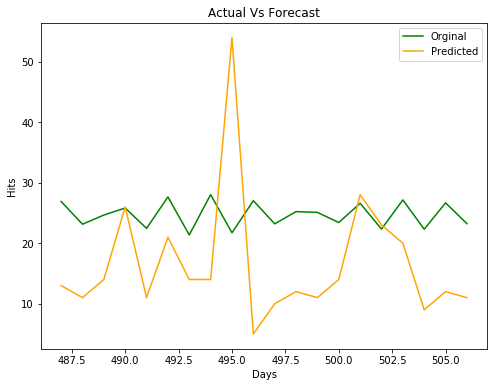

In [92]:
'''
from statsmodels.tsa.arima_model import ARIMA
df_actual= extract_series(y_train, 1, 2)
df_train = extract_series(X_train,1,2)
p=4
q=4
d=0
print("here")
arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=True)
'''
plt.subplot(2,1,1)

